## Imports

In [1]:
!pip install opencv-python
!pip install matplotlib
!pip install sklearn

import numpy as np
import cv2
import csv
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.utils import shuffle
import random

%tensorflow_version 2.x
import tensorflow as tf
import os

# tf1.disable_v2_behavior()

!pip install tensorflow-model-optimization
from tensorflow_model_optimization.sparsity import keras as sparsity

import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, Input, Activation, Lambda
from tensorflow.keras.layers import BatchNormalization, GlobalMaxPooling2D, MaxPooling2D, ZeroPadding2D, Add, Conv2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import optimizers
from time import time

## Utils

In [0]:
SIGN_SIZE = (32, 32)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.nasnet import NASNetMobile

def get_mobilenet(input_shape, num_classes, alpha):
   model = Sequential([
      MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet', alpha=alpha),
      GlobalMaxPooling2D(),
      Dense(num_classes, activation='softmax')
   ])
   return model

def get_nasnet(input_shape, num_classes):
   model = Sequential([
      NASNetMobile(input_shape=input_shape, include_top=False, weights='imagenet'),
      GlobalMaxPooling2D(),
      Dense(num_classes, activation='softmax')
   ])
   return model

def get_custom_model(input_shape, num_classes):
  model = Sequential()
  model.add(Conv2D(8, (5, 5), input_shape=input_shape, activation=tf.nn.leaky_relu))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(16, (3, 3), activation=tf.nn.leaky_relu))
  model.add(BatchNormalization())
  model.add(Conv2D(16, (3, 3), activation=tf.nn.leaky_relu))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(32, (3, 3), padding="same", activation=tf.nn.leaky_relu))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3, 3), padding="same", activation=tf.nn.leaky_relu))
  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(256, activation="relu"))

  model.add(Dense(num_classes, activation="softmax"))
  return model

In [0]:
def visualize_accuracy(data):
  # Visualize model
  plt.plot(data.history['accuracy'])
  plt.plot(data.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

def visualize_loss(data): 
  plt.plot(data.history['loss'])
  plt.plot(data.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

## Fetch Background images

In [4]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1sv4eqxI3qUebdwwtK9beRqTohoz6Om8f' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1sv4eqxI3qUebdwwtK9beRqTohoz6Om8f" -O background_images.zip && rm -rf /tmp/cookies.txt
!unzip background_images.zip

Streaming output truncated to the last 5000 lines.
  inflating: background_images/24264.jpg  
  inflating: background_images/29059.jpg  
  inflating: background_images/55090.jpg  
  inflating: background_images/49819.jpg  
  inflating: background_images/64892.jpg  
  inflating: background_images/58447.jpg  
  inflating: background_images/61451.jpg  
  inflating: background_images/53690.jpg  
  inflating: background_images/21015.jpg  
  inflating: background_images/37871.jpg  
  inflating: background_images/20660.jpg  
  inflating: background_images/50323.jpg  
  inflating: background_images/45641.jpg  
  inflating: background_images/53662.jpg  
  inflating: background_images/24519.jpg  
  inflating: background_images/38428.jpg  
  inflating: background_images/70017.jpg  
  inflating: background_images/19036.jpg  
  inflating: background_images/44565.jpg  
  inflating: background_images/33888.jpg  
  inflating: background_images/32612.jpg  
  inflating: background_images/57506.jpg  
  i

In [0]:
background_images = []

for image_path in os.listdir("background_images"):
   background_images.append(plt.imread("./background_images/" + image_path))

## Fetch Traffic Signs images

In [6]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ef-iuE14QfV9GO24wIWNvfd5mGU8IqCY' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ef-iuE14QfV9GO24wIWNvfd5mGU8IqCY" -O traffic_sign_images.zip && rm -rf /tmp/cookies.txt
!unzip traffic_sign_images.zip

Streaming output truncated to the last 5000 lines.
  inflating: traffic_sign_images/8095.jpg  
  inflating: traffic_sign_images/2796.jpg  
  inflating: traffic_sign_images/9543.jpg  
  inflating: traffic_sign_images/4675.jpg  
  inflating: traffic_sign_images/7227.jpg  
  inflating: traffic_sign_images/5918.jpg  
  inflating: traffic_sign_images/4694.jpg  
  inflating: traffic_sign_images/10103.jpg  
  inflating: traffic_sign_images/3119.jpg  
  inflating: traffic_sign_images/8078.jpg  
  inflating: traffic_sign_images/9397.jpg  
  inflating: traffic_sign_images/2485.jpg  
  inflating: traffic_sign_images/8224.jpg  
  inflating: traffic_sign_images/7168.jpg  
  inflating: traffic_sign_images/4048.jpg  
  inflating: traffic_sign_images/2234.jpg  
  inflating: traffic_sign_images/4658.jpg  
  inflating: traffic_sign_images/4384.jpg  
  inflating: traffic_sign_images/9667.jpg  
  inflating: traffic_sign_images/7840.jpg  
  inflating: traffic_sign_images/2840.jpg  
  inflating: traffic_sig

In [0]:
traffic_signs = []

for image_path in os.listdir("traffic_sign_images"):
   traffic_signs.append(plt.imread("./traffic_sign_images/" + image_path))

In [8]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB-Training_fixed.zip
!unzip GTSRB-Training_fixed.zip

Streaming output truncated to the last 5000 lines.
  inflating: GTSRB/Training/00030/00007_00025.ppm  
  inflating: GTSRB/Training/00030/00007_00026.ppm  
  inflating: GTSRB/Training/00030/00007_00027.ppm  
  inflating: GTSRB/Training/00030/00007_00028.ppm  
  inflating: GTSRB/Training/00030/00007_00029.ppm  
  inflating: GTSRB/Training/00030/00008_00000.ppm  
  inflating: GTSRB/Training/00030/00008_00001.ppm  
  inflating: GTSRB/Training/00030/00008_00002.ppm  
  inflating: GTSRB/Training/00030/00008_00003.ppm  
  inflating: GTSRB/Training/00030/00008_00004.ppm  
  inflating: GTSRB/Training/00030/00008_00005.ppm  
  inflating: GTSRB/Training/00030/00008_00006.ppm  
  inflating: GTSRB/Training/00030/00008_00007.ppm  
  inflating: GTSRB/Training/00030/00008_00008.ppm  
  inflating: GTSRB/Training/00030/00008_00009.ppm  
  inflating: GTSRB/Training/00030/00008_00010.ppm  
  inflating: GTSRB/Training/00030/00008_00011.ppm  
  inflating: GTSRB/Training/00030/00008_00012.ppm  
  inflating: 

In [0]:
def readGTSRB(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            image_resized = cv2.resize(plt.imread(prefix + row[0]), SIGN_SIZE)      
            images.append(image_resized) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels

In [0]:
gtrsrb_signs, gtrsrb_labels = readGTSRB('./GTSRB/Training')

## Data
0 => NO TRAFFIC SIGN

1 => IS TRAFFIC SIGN

### Show Data

10336


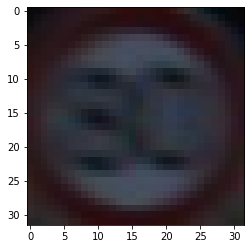

In [11]:
print(len(traffic_signs))
plt.imshow(traffic_signs[42])
plt.show()

26640


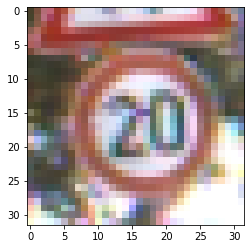

In [12]:
print(len(gtrsrb_signs))
plt.imshow(gtrsrb_signs[42])
plt.show()

71307


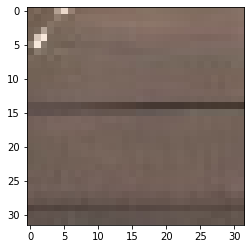

In [13]:
print(len(background_images))
plt.imshow(background_images[42])
plt.show()

### Prepare data

In [0]:
total_traffic_signs = shuffle(traffic_signs) + shuffle(gtrsrb_signs)
total_background_images = shuffle(background_images)[:int(len(total_traffic_signs))]

TRAIN_PERCENTAGE = 0.8
VAL_PERCENTAGE = 0.1

In [15]:
print(len(total_traffic_signs))
print(len(total_background_images))

36976
36976


In [0]:
total_images = total_background_images + total_traffic_signs
total_labels = [0] * len(total_background_images) + [1] * len(total_traffic_signs)

total_images, total_labels = shuffle(total_images, total_labels)

In [0]:
train_limit = int(TRAIN_PERCENTAGE * len(total_images))
val_limit = int(train_limit + VAL_PERCENTAGE * len(total_images))

tr_total_images = np.array(total_images)[:train_limit]
tr_total_labels = np.array(total_labels)[:train_limit]
va_total_images = np.array(total_images)[train_limit:val_limit]
va_total_labels = np.array(total_labels)[train_limit:val_limit]
te_total_images = np.array(total_images)[val_limit:]
te_total_labels = np.array(total_labels)[val_limit:]

In [0]:
tr_total_images = tr_total_images.astype('float32')
va_total_images = va_total_images.astype('float32')
te_total_images = te_total_images.astype('float32')

tr_total_images /= 255.0
va_total_images /= 255.0
te_total_images /= 255.0

## Train Background CNN - Without Preprocessing




In [0]:
is_traffic_sign_model = get_mobilenet(input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3), num_classes = 2, alpha=0.5) # get_custom_model(input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3), num_classes = 2)
is_traffic_sign_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer="Adam", 
              metrics=['accuracy'])

is_traffic_sign_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_0.50_224 (Model) (None, 1, 1, 1280)        706224    
_________________________________________________________________
global_max_pooling2d_5 (Glob (None, 1280)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 2562      
Total params: 708,786
Trainable params: 690,242
Non-trainable params: 18,544
_________________________________________________________________


In [0]:
is_traffic_sign_model_data = is_traffic_sign_model.fit(tr_total_images, tr_total_labels,
        batch_size=64,
        epochs=30,
        verbose=2,
        validation_data=(va_total_images, va_total_labels))

Epoch 1/30
925/925 - 19s - loss: 0.3712 - accuracy: 0.9407 - val_loss: 0.4650 - val_accuracy: 0.8475
Epoch 2/30
925/925 - 18s - loss: 0.3468 - accuracy: 0.9655 - val_loss: 0.6686 - val_accuracy: 0.6613
Epoch 3/30
925/925 - 18s - loss: 0.3394 - accuracy: 0.9731 - val_loss: 0.6447 - val_accuracy: 0.7007
Epoch 4/30
925/925 - 19s - loss: 0.3507 - accuracy: 0.9619 - val_loss: 0.8166 - val_accuracy: 0.4970
Epoch 5/30
925/925 - 18s - loss: 0.3326 - accuracy: 0.9804 - val_loss: 0.4340 - val_accuracy: 0.8728
Epoch 6/30
925/925 - 18s - loss: 0.3496 - accuracy: 0.9629 - val_loss: 0.3580 - val_accuracy: 0.9547
Epoch 7/30
925/925 - 18s - loss: 0.3351 - accuracy: 0.9770 - val_loss: 0.3453 - val_accuracy: 0.9682
Epoch 8/30
925/925 - 18s - loss: 0.3320 - accuracy: 0.9811 - val_loss: 0.4034 - val_accuracy: 0.9139
Epoch 9/30
925/925 - 18s - loss: 0.3332 - accuracy: 0.9795 - val_loss: 0.3651 - val_accuracy: 0.9483
Epoch 10/30
925/925 - 18s - loss: 0.3346 - accuracy: 0.9783 - val_loss: 0.3701 - val_accura

In [0]:
start = time()
loss, acc = is_traffic_sign_model.evaluate(te_total_images, te_total_labels, verbose=1)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

232/232 [==============================] - 1s 6ms/step - loss: 0.3219 - accuracy: 0.9908
CNN took 1.5209362506866455 seconds
Test loss: 0.32190006971359253 - Accuracy: 0.9908058643341064


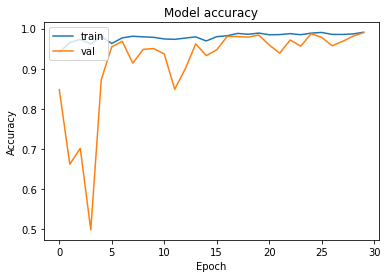

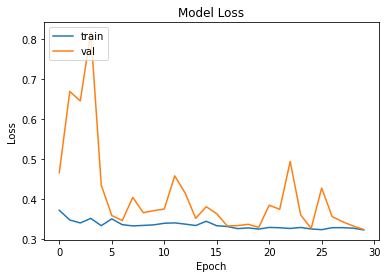

In [0]:
visualize_accuracy(is_traffic_sign_model_data)
visualize_loss(is_traffic_sign_model_data)

## Train Background CNN - With Preprocessing

In [0]:
datagen = ImageDataGenerator(
	  zoom_range=0.1,
	  width_shift_range=0.1,
	  height_shift_range=0.1,
    fill_mode='nearest')
datagen.fit(tr_total_images, augment=True)

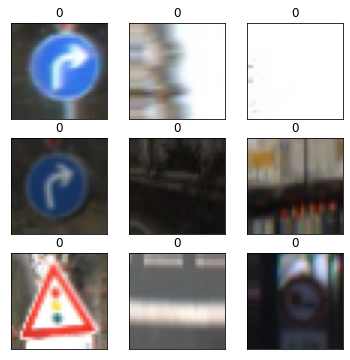

In [20]:
for x_batch, y_batch in datagen.flow(tr_total_images, tr_total_labels, batch_size=64):
    # create a grid of 3x3 images
    fig = plt.figure(figsize=(6,6))
    for i in range(0, 9):
        ax = fig.add_subplot(3, 3, 1 + i, xticks=[], yticks=[])
        ax.set_title(np.argmax(y_batch[i]))
        plt.imshow(x_batch[i])
    # show the plot
    plt.show()
    break

In [28]:
is_traffic_sign_preproc_model = get_mobilenet(input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3), num_classes = 2, alpha=0.5) # get_custom_model(input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3), num_classes = 2)
is_traffic_sign_preproc_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer="Adamax",
              metrics=['accuracy'])

is_traffic_sign_preproc_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_0.50_224 (Model) (None, 1, 1, 1280)        706224    
_________________________________________________________________
global_max_pooling2d_3 (Glob (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2562      
Total params: 708,786
Trainable params: 690,242
Non-trainable params: 18,544
_________________________________________________________________


In [30]:
batch_size = 32
train_steps = int(len(tr_total_images) // batch_size)
valid_steps = int(len(va_total_images) // batch_size)

is_traffic_sign_preproc_model_data = is_traffic_sign_preproc_model.fit(datagen.flow(tr_total_images, tr_total_labels, batch_size=batch_size), 
                         epochs=45, 
                         steps_per_epoch=train_steps, 
                         verbose=2, 
                         validation_data=(va_total_images, va_total_labels), 
                         validation_steps=valid_steps)

Epoch 1/45
1848/1848 - 52s - loss: 0.3682 - accuracy: 0.9432 - val_loss: 0.4253 - val_accuracy: 0.9496
Epoch 2/45
1848/1848 - 50s - loss: 0.3425 - accuracy: 0.9703 - val_loss: 0.3352 - val_accuracy: 0.9792
Epoch 3/45
1848/1848 - 50s - loss: 0.3346 - accuracy: 0.9781 - val_loss: 0.3258 - val_accuracy: 0.9878
Epoch 4/45
1848/1848 - 50s - loss: 0.3332 - accuracy: 0.9796 - val_loss: 0.3250 - val_accuracy: 0.9880
Epoch 5/45
1848/1848 - 50s - loss: 0.3299 - accuracy: 0.9829 - val_loss: 0.3251 - val_accuracy: 0.9877
Epoch 6/45
1848/1848 - 50s - loss: 0.3294 - accuracy: 0.9836 - val_loss: 0.3254 - val_accuracy: 0.9873
Epoch 7/45
1848/1848 - 50s - loss: 0.3297 - accuracy: 0.9831 - val_loss: 0.3246 - val_accuracy: 0.9872
Epoch 8/45
1848/1848 - 50s - loss: 0.3276 - accuracy: 0.9855 - val_loss: 0.3222 - val_accuracy: 0.9908
Epoch 9/45
1848/1848 - 50s - loss: 0.3277 - accuracy: 0.9854 - val_loss: 0.3217 - val_accuracy: 0.9915
Epoch 10/45
1848/1848 - 50s - loss: 0.3271 - accuracy: 0.9858 - val_loss:

In [31]:
# MobieNet 0.5
start = time()
loss, acc = is_traffic_sign_preproc_model.evaluate(te_total_images, te_total_labels, verbose=1)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

232/232 [==============================] - 2s 10ms/step - loss: 0.3172 - accuracy: 0.9957
CNN took 2.3352739810943604 seconds
Test loss: 0.31723785400390625 - Accuracy: 0.9956733584403992


In [0]:
# MobieNet 0.5
start = time()
loss, acc = is_traffic_sign_preproc_model.evaluate(te_total_images, te_total_labels, verbose=1)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

232/232 [==============================] - 1s 6ms/step - loss: 0.3203 - accuracy: 0.9924
CNN took 1.4713554382324219 seconds
Test loss: 0.32032328844070435 - Accuracy: 0.9924283623695374


In [0]:
# MobieNet 1.0
start = time()
loss, acc = is_traffic_sign_preproc_model.evaluate(te_total_images, te_total_labels, verbose=1)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

232/232 [==============================] - 2s 7ms/step - loss: 0.3222 - accuracy: 0.9911
CNN took 1.7481398582458496 seconds
Test loss: 0.3221867084503174 - Accuracy: 0.9910762310028076


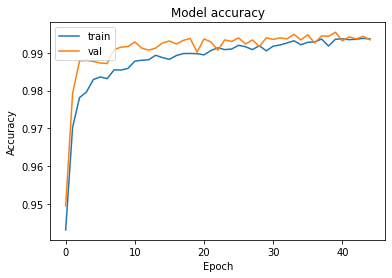

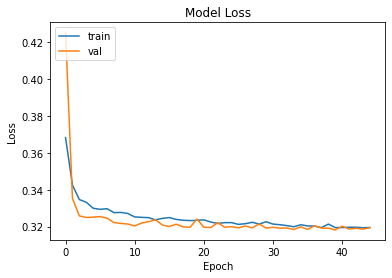

In [32]:
# MobieNet 0.5
visualize_accuracy(is_traffic_sign_preproc_model_data)
visualize_loss(is_traffic_sign_preproc_model_data)

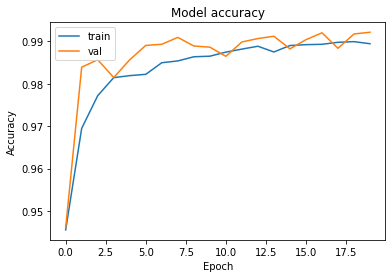

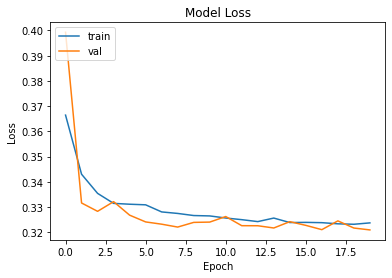

In [0]:
# Mobilenet@0.5
visualize_accuracy(is_traffic_sign_preproc_model_data)
visualize_loss(is_traffic_sign_preproc_model_data)

## Save model

In [0]:
is_traffic_sign_model = is_traffic_sign_preproc_model

In [34]:
!mkdir is_traffic_sign_model
!rm -rf is_traffic_sign_model/*
is_traffic_sign_model.save_weights("is_traffic_sign_model/is_traffic_sign_model")
!zip -r is_traffic_sign_model.zip is_traffic_sign_model

  adding: is_traffic_sign_model/ (stored 0%)
  adding: is_traffic_sign_model/is_traffic_sign_model.data-00001-of-00002 (deflated 8%)
  adding: is_traffic_sign_model/is_traffic_sign_model.data-00000-of-00002 (deflated 90%)
  adding: is_traffic_sign_model/is_traffic_sign_model.index (deflated 81%)
  adding: is_traffic_sign_model/checkpoint (deflated 42%)


## Test

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
0
[1.000000e+00 5.555698e-16]


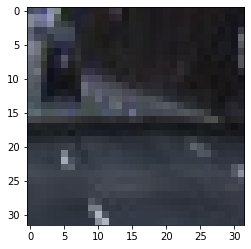

In [35]:
index = 329
img = te_total_images[index]
img_resized = np.reshape(img, [1, 32, 32, 3])
plt.imshow(img)
print(is_traffic_sign_model.predict_classes(img_resized)[0])
print(is_traffic_sign_model.predict(img_resized).flatten())

[[1. 0.]]


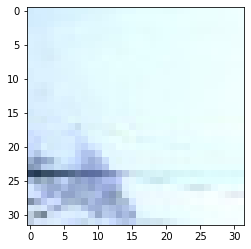

In [0]:
index = 422
plt.imshow(background_images[index])
# print(is_traffic_sign_model.predict_classes([[background_images[index]]])[0])
print(is_traffic_sign_model.predict_proba(np.reshape(background_images[index], [1, 32, 32,3])))